In [ ]:
%load_ext autoreload
%autoreload 2

In [15]:
from dataset import IHarmDataset, get_train_preprocessing, get_inference_preprocessing, get_augmentation
from unet import UNet, AttentionUNet, HistNet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as albu
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np
import cv2

#     if denormalize:
#         mean = [0.485, 0.456, 0.406]
#         std = [0.229, 0.224, 0.225]
#         im[0, :, :] = im[0, :, :] * std[0] + mean[0]
#         im[1, :, :] = im[1, :, :] * std[1] + mean[1]
#         im[2, :, :] = im[2, :, :] * std[2] + mean[2]
    
def show(im):
    plt.figure()
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    
def post(im, resize=None):
    im_ = np.transpose(im, (2, 1, 0))
    im_ = 0.5 * (im_ + 1)
    im_ = (255 * im_).astype(np.uint8)
    im_ = cv2.cvtColor(im_, cv2.COLOR_LAB2BGR)
    if resize is not None:
        im_ = cv2.resize(im_, (resize, resize), cv2.INTER_LINEAR)
    im_ = np.rot90(im_, 3)
    return im_

In [3]:
device = "cpu"
# cp = "checkpoints/cp_HistNet_tanh_poisson_epoch_9.pth"
net = AttentionUNet(7, 3)
net.to(device)
# net.load_state_dict(torch.load(cp))

AttentionUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

# Train Outputs

In [4]:
datapath = "../image_harmonization/HAdobe5k/"
preprocessing = get_train_preprocessing() # get_inference_preprocessing() #
dataset = IHarmDataset(datapath, preprocessing, None, LAB=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [18]:
results = []
resize = None

for _ in range(5):
    batch = next(iter(dataloader))
    c, m, h, r = batch["comp"], batch["mask"], batch["hist"], batch["real"]

    with torch.no_grad():
        p = net(c.to(device), m.to(device), h.to(device))

    c_ = post(c.detach().cpu().numpy()[0], resize=resize)
    p_ = post(p.detach().cpu().numpy()[0], resize=resize)
    r_ = post(r.detach().cpu().numpy()[0], resize=resize)
    
    result = np.vstack([c_, p_, r_])
    results.append(result)
        
results = np.hstack(results)

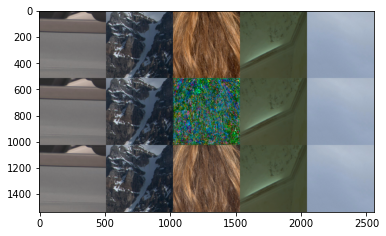

In [19]:
show(results)

In [9]:
cv2.imwrite("results_hist_net_poisson.jpg", results)

True